In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangla-newspaper-dataset/data_v2/data_v2.json
/kaggle/input/bangla-newspaper-dataset/data/data.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/model.safetensors.index.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/config.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/model-00001-of-00002.safetensors
/kaggle/input/llama-3.2/transformers/3b-instruct/1/model-00002-of-00002.safetensors
/kaggle/input/llama-3.2/transformers/3b-instruct/1/README.md
/kaggle/input/llama-3.2/transformers/3b-instruct/1/USE_POLICY.md
/kaggle/input/llama-3.2/transformers/3b-instruct/1/tokenizer.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/tokenizer_config.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/LICENSE.txt
/kaggle/input/llama-3.2/transformers/3b-instruct/1/special_tokens_map.json
/kaggle/input/llama-3.2/transformers/3b-instruct/1/.gitattributes
/kaggle/input/llama-3.2/transformers/3b-instruct/1/generation_config.json


In [2]:
%pip install llama-stack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=43602df2b297b4ed38066ee2ee120ae116afd6cba982746395ce3080ae95e0e4
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [4]:
!pip install wandb
#!wandb login

In [5]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune llama-3.2-3b-it on Newspaper Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cse-mahmud-evan (cse-mahmud-evan-ccn-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241005_171954-blq572vw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sage-pine-2
wandb: ⭐️ View project at https://wandb.ai/cse-mahmud-evan-ccn-university-of-science-and-technology/Fine-tune%20llama-3.2-3b-it%20on%20Newspaper%20Dataset
wa

In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging
)
from sklearn.metrics import (

    accuracy_score,
    classification_report,
    confusion_matrix   
)
from sklearn.model_selection import train_test_split

In [7]:
import numpy as np
import pandas as pd

data = pd.read_json('/kaggle/input/bangla-newspaper-dataset/data_v2/data_v2.json')
data.head()

,author,category,category_bn,published_date,modification_date,tag,comment_count,title,url,content
0,গাজীপুর প্রতিনিধি,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২৩:২৬","০৪ জুলাই ২০১৩, ২৩:২৭",[গাজীপুর],0,"কালিয়াকৈরে টিফিন খেয়ে ৫০০ শ্রমিক অসুস্থ, বিক...",http://www.prothom-alo.com/bangladesh/article/...,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...
1,অনলাইন ডেস্ক,sports,খেলা,"০৪ জুলাই ২০১৩, ২৩:০৯","০৪ জুলাই ২০১৩, ২৩:১১",[টেনিস],0,সেমিফাইনাল বাধাও পেরিয়ে গেলেন লিসিকি,http://www.prothom-alo.com/sports/article/19028,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...
2,নিজস্ব প্রতিবেদক,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২২:২৫","০৪ জুলাই ২০১৩, ২৩:১২",[রাজনীতি],0,সংসদে খালেদার অভিযোগের জবাব দিয়েছে ভারত,http://www.prothom-alo.com/bangladesh/article/...,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...
3,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৭","০৪ জুলাই ২০১৩, ২১:৪৫",[গবেষণা],0,পাসওয়ার্ড ভুলে যান!,http://www.prothom-alo.com/technology/article/...,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...
4,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৫","০৪ জুলাই ২০১৩, ২১:৩৭",[কম্পিউটার],0,চলে গেলেন মাউস উদ্ভাবক,http://www.prothom-alo.com/technology/article/...,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...


In [8]:
len(data.columns)

10

In [9]:
ndf = data[['content','category']]

In [10]:
ndf.shape

(408471, 2)

In [11]:
ndf.duplicated().sum()

1567

In [12]:
ndf.drop_duplicates(inplace= True)

/tmp/ipykernel_23/3272145479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.drop_duplicates(inplace= True)


In [13]:
ndf.shape

(406904, 2)

In [14]:
ndf.category.unique()

array(['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education'],
      dtype=object)

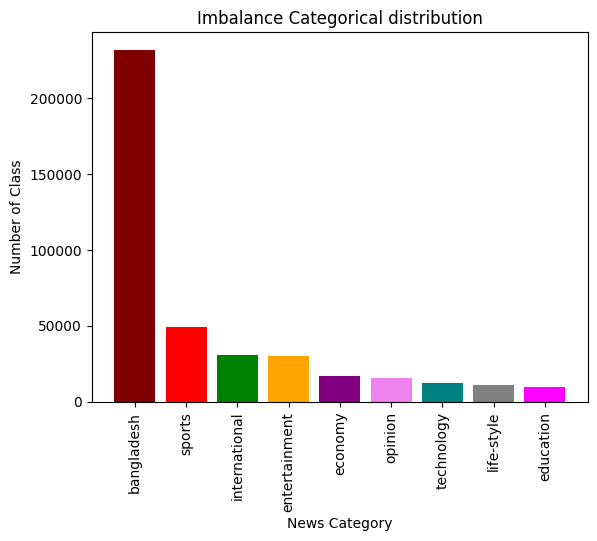

In [15]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt


color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

labels = ndf['category'].value_counts().index
values = ndf['category'].value_counts().values

plt.bar(labels,values, color = color_palette)
plt.title("Imbalance Categorical distribution")
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of Class')



plt.show()

In [16]:
ndf.head()

,content,category
0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,bangladesh
1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,sports
2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,bangladesh
3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,technology
4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,technology


In [17]:
!pip install imblearn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [18]:

from imblearn.under_sampling import RandomUnderSampler

A = ndf.drop('category',axis = 1)
b = ndf['category']

rus = RandomUnderSampler()

A_resampled, b_resampled = rus.fit_resample(A,b)

resampled_df = pd.DataFrame(A_resampled,columns = A.columns)
resampled_df['category'] = b_resampled

resampled_df = resampled_df.sample(frac = 1, random_state = 85).reset_index (drop=True)

In [19]:
resampled_df.head()

,content,category
0,২ টাকা থেকে ৫০০ টাকার নোট স্ক্যান করে স্বাধীনত...,technology
1,গত অর্থবছরে (২০১৬-১৭) মোট দেশজ উৎপাদনের প্রবৃদ...,economy
2,মেষ ২১ মার্চ-২০ এপ্রিল। ভর # ৬পথ চলাতে আপনার য...,life-style
3,অনেক জল্পনাকল্পনা এবং আশঙ্কার মধ্য দিয়ে শেষ হ...,opinion
4,"অধ্যায়-৩ প্রিয় শিক্ষার্থী, আজ প্রাথমিক বিজ্ঞা...",education


In [20]:
resampled_df.shape

(86868, 2)

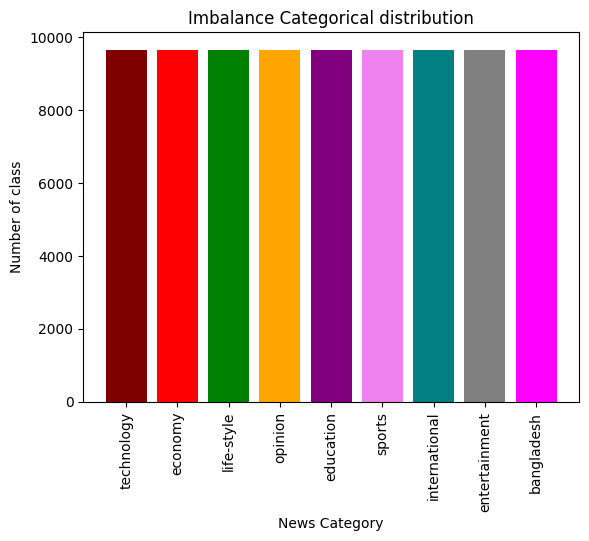

In [21]:
#category distribution
labels = resampled_df['category'].value_counts().index
values = resampled_df['category'].value_counts().values

color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

#plot bar chart
plt.bar(labels,values, color = color_palette)
plt.title('Imbalance Categorical distribution')
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of class')
plt.show()

In [22]:
resampled_df['category'].value_counts()

category
technology       9652
economy          9652
life-style       9652
opinion          9652
education        9652
sports           9652
international    9652
entertainment    9652
bangladesh       9652
Name: count, dtype: int64

In [23]:
ndf = resampled_df.sample(frac= 1, random_state = 48).reset_index(drop=True).head(5000)
ndf.head()

,content,category
0,যুক্তরাষ্ট্রের আগামী প্রেসিডেন্ট নির্বাচনে ডেম...,international
1,ফিরছেন ইশান্ত শর্মা। মশাবাহিত চিকুনগুনিয়া জ্বর...,sports
2,পৃথিবীর প্রথম স্মার্টকোট তৈরি করা হচ্ছে যুক্তর...,technology
3,চীনের পূর্বাঞ্চলে গতকাল শনিবার বিকেলে স্মরণকাল...,international
4,ভয়াবহ এক শুরুর পর ইনিংসের শেষটা অবশ্যই তৃপ্তি ...,sports


In [24]:
train_size = 0.8
val_size = 0.1

train_end = int(train_size * len(ndf)) 
val_end = train_end + int(val_size * len(ndf))

In [25]:
X_train = ndf[:train_end]
X_val = ndf[train_end:val_end]
X_test = ndf[val_end:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4000, 2)
(500, 2)
(500, 2)


In [26]:
# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: {data_point["category"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: """.strip()

In [27]:
X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)
X_train.head()

/tmp/ipykernel_23/605730108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)


,content,category,text
0,যুক্তরাষ্ট্রের আগামী প্রেসিডেন্ট নির্বাচনে ডেম...,international,"Classify the text into bangladesh, sports, tec..."
1,ফিরছেন ইশান্ত শর্মা। মশাবাহিত চিকুনগুনিয়া জ্বর...,sports,"Classify the text into bangladesh, sports, tec..."
2,পৃথিবীর প্রথম স্মার্টকোট তৈরি করা হচ্ছে যুক্তর...,technology,"Classify the text into bangladesh, sports, tec..."
3,চীনের পূর্বাঞ্চলে গতকাল শনিবার বিকেলে স্মরণকাল...,international,"Classify the text into bangladesh, sports, tec..."
4,ভয়াবহ এক শুরুর পর ইনিংসের শেষটা অবশ্যই তৃপ্তি ...,sports,"Classify the text into bangladesh, sports, tec..."


In [28]:
X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)
X_val.head()

/tmp/ipykernel_23/1181508762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)


,content,category,text
4000,নির্বাচনকালীন সরকারের তথ্যমন্ত্রী হাসানুল হক ই...,bangladesh,"Classify the text into bangladesh, sports, tec..."
4001,আগামী ফেব্রুয়ারি থেকে মাধ্যমিক পরীক্ষা দেবেন অ...,entertainment,"Classify the text into bangladesh, sports, tec..."
4002,বয়সে ম্যাটস হামেলসের চেয়ে দুই বছরের বড় ডেভিড ল...,sports,"Classify the text into bangladesh, sports, tec..."
4003,"মহাকাশের বিভিন্ন গ্রহ-উপগ্রহ, তারকা নিয়ে যাঁদে...",education,"Classify the text into bangladesh, sports, tec..."
4004,ফতুল্লায় একদিনের প্রস্তুতি ম্যাচে টসে জিতে প্...,sports,"Classify the text into bangladesh, sports, tec..."


In [29]:
X_test.head()

,content,category
4500,চিকিৎসক কম্পিউটারেই লিখতে পারবেন রোগীর ব্যবস্থ...,technology
4501,যুক্তরাষ্ট্রের ওয়াশিংটন ডিসিতে আজ অনুষ্ঠিত হবে...,bangladesh
4502,আজ সকালে যখন দিল্লির বিমানে উড়াল দিয়েছেন মাশরা...,sports
4503,প্রেমের সম্পর্ক ভেঙে যাওয়ায় রাশিয়ায় এক ব্য...,international
4504,একটি লাড্ডুর আকার বা ওজন আর কতই বা হতে পারে। ক...,international


In [30]:
y_true = X_test.loc[:,'category']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis = 1), columns = ['text'])

In [31]:
X_test.head()

,text
4500,"Classify the text into bangladesh, sports, tec..."
4501,"Classify the text into bangladesh, sports, tec..."
4502,"Classify the text into bangladesh, sports, tec..."
4503,"Classify the text into bangladesh, sports, tec..."
4504,"Classify the text into bangladesh, sports, tec..."


In [32]:
X_val.shape

(500, 3)

In [33]:
y_true.head()

4500       technology
4501       bangladesh
4502           sports
4503    international
4504    international
Name: category, dtype: object

In [34]:
X_test.head()

,text
4500,"Classify the text into bangladesh, sports, tec..."
4501,"Classify the text into bangladesh, sports, tec..."
4502,"Classify the text into bangladesh, sports, tec..."
4503,"Classify the text into bangladesh, sports, tec..."
4504,"Classify the text into bangladesh, sports, tec..."


In [35]:
X_train.category.value_counts()

category
international    485
education        464
opinion          454
entertainment    446
life-style       444
bangladesh       430
sports           427
technology       426
economy          424
Name: count, dtype: int64

In [36]:
y_true.value_counts()

category
education        70
life-style       60
sports           59
entertainment    56
bangladesh       56
international    51
economy          50
opinion          50
technology       48
Name: count, dtype: int64

In [37]:
from datasets import Dataset
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
val_data = Dataset.from_pandas(X_val[["text"]])

In [38]:
print(train_data)
print(val_data)

Dataset({
    features: ['text'],
    num_rows: 4000
})
Dataset({
    features: ['text'],
    num_rows: 500
})


In [39]:
train_data['text'][3]

'Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.\ntext: চীনের পূর্বাঞ্চলে গতকাল শনিবার বিকেলে স্মরণকালের মধ্যে শক্তিশালী টাইফুন ‘চান-হাম’ আঘাত হানায় আকাশ, রেল ও সমুদ্রপথে যোগাযোগ ব্যাহত হচ্ছে। দুটি প্রদেশ থেকে প্রায় ১০ লাখ মানুষকে নিরাপদ আশ্রয়ে সরিয়ে নেওয়া হয়েছে। তবে এ ঘটনায় হতাহতের কোনো খবর পাওয়া যায়নি।\nlabel: international'

In [40]:
test_data = Dataset.from_pandas(X_test[["text"]])

In [41]:
test_data['text'][1]

'Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.\ntext: যুক্তরাষ্ট্রের ওয়াশিংটন ডিসিতে আজ অনুষ্ঠিত হবে বাংলাদেশ ও যুক্তরাষ্ট্রের মধ্যকার চতুর্থ নিরাপত্তা সংলাপ। সন্ত্রাসবাদ মোকাবিলায় সহযোগিতাসহ আঞ্চলিক সহযোগিতা এবং প্রথাগত ও অ-প্রথাগত নিরাপত্তা ইস্যুতে আলোচনা করবে এ দুই দেশ। খবর ইউএনবির।বাংলাদেশের পররাষ্ট্র দপ্তর বলছে, সাইবার নিরাপত্তা, দুর্যোগ ব্যবস্থাপনা, সামরিক সহযোগিতা ও জাতিসংঘের শান্তিরক্ষা কার্যক্রমের মতো ইস্যুতে সংলাপে আলোচনা হবে। এর মধ্য দিয়ে দুই দেশের সম্পর্ক জোরদার হবে বলে আশা করছে বাংলাদেশ।সংলাপে অংশ নিতে এরই মধ্যে যুক্তরাষ্ট্রে গেছেন ঢাকায় নিযুক্ত মার্কিন রাষ্ট্রদূত মার্শা বার্নিকাট এবং বাংলাদেশের স্বরাষ্ট্র, পররাষ্ট্র ও প্রতিরক্ষা মন্ত্রণালয় এবং সশস্ত্র বাহিনী বিভাগের প্রতিনিধিদের সমন্বয়ে গঠিত প্রতিনিধিদল। পররাষ্ট্র মন্ত্রণালয়ের একজন কর্মকর্তা জানান, সংলাপে বাংলাদেশের ছয় সদস্যের প্রতিনিধিদলের নেতৃত্ব দেবেন পররাষ্ট্রসচিব (দ

In [42]:
base_model_name = '/kaggle/input/llama-3.2/transformers/3b-instruct/1'

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = False,
    bnb_4bit_quant_type = 'nf4',
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_compute_dtype = 'float16')


model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    quantization_config=bnb_config, 
)

model.config._use_cache = False
model.config.pretaining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token_id  = tokenizer.eos_token_id

In [44]:
def predict(test,model,tokenizer):
    y_pred = []
    categories = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']


    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=2, 
                        temperature=0.1,
                        torch_dtype=torch.float16)
        
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()
        
        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")
    
    return y_pred

In [45]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 500/500 [20:36<00:00,  2.47s/it]


In [46]:
def evaluate(y_true, y_pred):
    labels = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']
    mapping = {label: idx for idx, label in enumerate(labels)}
    
    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data
    
    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [47]:
evaluate(y_true, y_pred)

Accuracy: 0.152
Accuracy for label bangladesh: 0.036
Accuracy for label sports: 0.576
Accuracy for label technology: 0.208
Accuracy for label entertainment: 0.268
Accuracy for label international: 0.078
Accuracy for label economy: 0.180
Accuracy for label life-style: 0.000
Accuracy for label opinion: 0.040
Accuracy for label education: 0.000

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.12      0.04      0.06        56
       sports       0.63      0.58      0.60        59
   technology       0.83      0.21      0.33        48
entertainment       0.83      0.27      0.41        56
international       0.57      0.08      0.14        51
      economy       0.47      0.18      0.26        50
   life-style       0.00      0.00      0.00        60
      opinion       1.00      0.04      0.08        50
    education       0.00      0.00      0.00        70

    micro avg       0.59      0.15      0.24       500
    macro avg       0.50 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


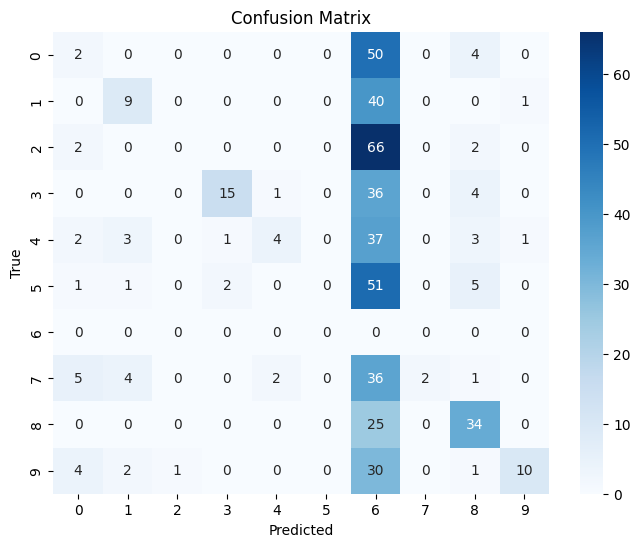

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [49]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [50]:
modules = find_all_linear_names(model)
modules

['gate_proj', 'down_proj', 'up_proj', 'q_proj', 'k_proj', 'o_proj', 'v_proj']

In [51]:
output_dir="llama-3.2 3b model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,                         
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="wandb",                  # report metrics to w&b
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=256,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:327: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [52]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), d

Step,Training Loss,Validation Loss
100,0.837300,0.806590
200,0.867600,0.774609
300,0.773400,0.755247
400,0.809400,0.744412
500,0.677500,0.742694


TrainOutput(global_step=500, training_loss=0.7900933918952942, metrics={'train_runtime': 5256.086, 'train_samples_per_second': 0.761, 'train_steps_per_second': 0.095, 'total_flos': 1.7450505239814144e+16, 'train_loss': 0.7900933918952942, 'epoch': 1.0})

In [53]:
wandb.finish()
model.config.use_cache = True

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss █▄▂▁▁
wandb:            eval/runtime ▅█▄▁▃
wandb: eval/samples_per_second ▄▁▄██
wandb:   eval/steps_per_second ▁▁▁▁▁
wandb:             train/epoch ▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
wandb:       train/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
wandb:         train/grad_norm ▃█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁
wandb:     train/learning_rate ▃▇████████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:              train/loss █▄▄▄▄▄▂▄▄▄▃▃▃▄▃▃▂▃▂▂▂▃▃▃▁▂▂▃▃▃▂▂▃▁▂▁▃▃▃▃
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.74269
wandb:             eval/runtime 139.2514
wandb:  eval/samples_per_second 3.591
wandb:    eval/steps_per_second 0.452
wandb:               total_flos 1.7450505239814144e+16
wandb:              train/epoch 1
wandb:        train/global_step 500
wandb:          train/grad_norm 0.39168
wandb:      train/learning_

In [54]:
#Save Train Model and Tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.2 3b model/tokenizer_config.json',
 'llama-3.2 3b model/special_tokens_map.json',
 'llama-3.2 3b model/tokenizer.json')

In [55]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 500/500 [22:27<00:00,  2.69s/it]


In [56]:
evaluate(y_true, y_pred)

Accuracy: 0.528
Accuracy for label bangladesh: 0.000
Accuracy for label sports: 0.983
Accuracy for label technology: 0.854
Accuracy for label entertainment: 1.000
Accuracy for label international: 0.059
Accuracy for label economy: 0.840
Accuracy for label life-style: 0.233
Accuracy for label opinion: 0.140
Accuracy for label education: 0.614

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.00      0.00      0.00        56
       sports       0.79      0.98      0.88        59
   technology       0.89      0.85      0.87        48
entertainment       0.39      1.00      0.56        56
international       0.75      0.06      0.11        51
      economy       0.46      0.84      0.60        50
   life-style       0.74      0.23      0.35        60
      opinion       1.00      0.14      0.25        50
    education       0.61      0.61      0.61        70

    micro avg       0.58      0.53      0.55       500
    macro avg       0.63 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


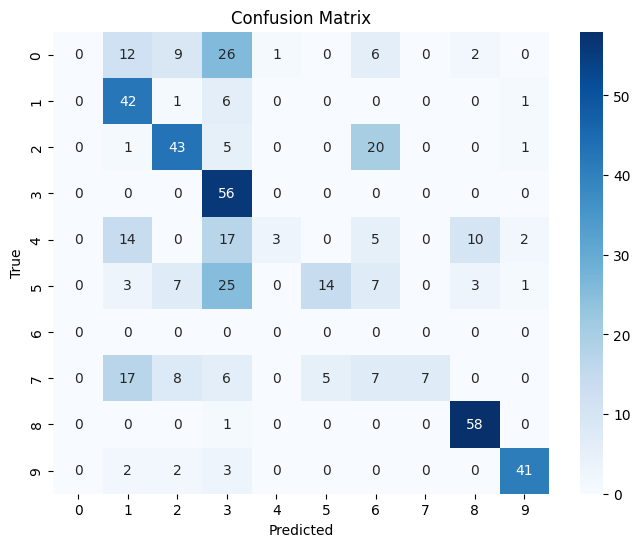

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()